In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = 0.8

In [3]:
from nltk.corpus import stopwords

In [4]:
df = pd.read_csv('transcription_samples.csv', usecols=['medical_specialty', 'transcription'])

In [5]:
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [6]:
df = df.dropna()

In [7]:
df.medical_specialty.value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [8]:
######### balancing dataset
def balance_dataset(df):
    df1 = df[df.medical_specialty == ' Consult - History and Phy.'].iloc[:355]
    df2 = df[df.medical_specialty == ' Cardiovascular / Pulmonary'].iloc[:355]
    df3 = df[df.medical_specialty == ' Orthopedic'].iloc[:355]
    df4 = df[df.medical_specialty == ' Surgery'].iloc[:355]
    
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)

df = balance_dataset(df)

In [9]:
### shuffling the dataset
from sklearn.utils import shuffle
df = shuffle(df)

In [10]:
df

,medical_specialty,transcription
2283,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Right carpal tunnel ..."
4894,Cardiovascular / Pulmonary,"SUBJECTIVE: , The patient is not in acute dist..."
2342,Orthopedic,"PREOPERATIVE DIAGNOSES,1. Cervical radiculopa..."
2299,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Hallux abductovalg..."
2363,Orthopedic,"PREOPERATIVE DIAGNOSES,1. Herniated nucleus p..."
...,...,...
4787,Cardiovascular / Pulmonary,"PROCEDURE PERFORMED:, Right heart catheteriza..."
4777,Cardiovascular / Pulmonary,"NAME OF PROCEDURE: , Left heart catheterizatio..."
4789,Cardiovascular / Pulmonary,"SUBJECTIVE: , This is a 42-year-old white fema..."
2286,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Left carpal tunnel s..."


In [11]:
df = df.reset_index(drop=True)

In [12]:
#### encoding the class
df['medical_specialty'] = df['medical_specialty'].astype('category')
df["medical_specialty_cat"] = df["medical_specialty"].cat.codes

In [13]:
messages = df.transcription.tolist()
labels = df['medical_specialty_cat']

In [14]:
########## finding map class to integer value #############
class0 = df[df.medical_specialty_cat == 0].iloc[0].medical_specialty
class1 = df[df.medical_specialty_cat == 1].iloc[0].medical_specialty
class2 = df[df.medical_specialty_cat == 2].iloc[0].medical_specialty
class3 = df[df.medical_specialty_cat == 3].iloc[0].medical_specialty
classes = {0 : class0, 1 : class1, 2 : class2, 3 : class3}

In [15]:
print(classes)

{0: ' Cardiovascular / Pulmonary', 1: ' Consult - History and Phy.', 2: ' Orthopedic', 3: ' Surgery'}


In [16]:
df

,medical_specialty,transcription,medical_specialty_cat
0,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Right carpal tunnel ...",2
1,Cardiovascular / Pulmonary,"SUBJECTIVE: , The patient is not in acute dist...",0
2,Orthopedic,"PREOPERATIVE DIAGNOSES,1. Cervical radiculopa...",2
3,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Hallux abductovalg...",2
4,Orthopedic,"PREOPERATIVE DIAGNOSES,1. Herniated nucleus p...",2
...,...,...,...
1415,Cardiovascular / Pulmonary,"PROCEDURE PERFORMED:, Right heart catheteriza...",0
1416,Cardiovascular / Pulmonary,"NAME OF PROCEDURE: , Left heart catheterizatio...",0
1417,Cardiovascular / Pulmonary,"SUBJECTIVE: , This is a 42-year-old white fema...",0
1418,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Left carpal tunnel s...",2


In [17]:
messages

['PREOPERATIVE DIAGNOSIS: , Right carpal tunnel syndrome.,POSTOPERATIVE DIAGNOSIS:,  Right carpal tunnel syndrome.,PROCEDURE PERFORMED: , Right carpal tunnel release.,PROCEDURE NOTE:  ,The right upper extremity was prepped and draped in the usual fashion.  IV sedation was supplied by the anesthesiologist.  A local block using 6 cc of 0.5% Marcaine was used at the transverse wrist crease using a 25 gauge needle, superficial to the transverse carpal ligament.,The upper extremity was exsanguinated with a 6 inch ace wrap.,Tourniquet time was less than 10 minutes at 250 mmHg.,An incision was used in line with the third web space just to the ulnar side of the thenar crease.  It was carried sharply down to the transverse wrist crease.  The transverse carpal ligament was identified and released under direct vision.  Proximal to the transverse wrist crease it was released subcutaneously.  During the entire procedure care was taken to avoid injury to the median nerve proper, the recurrent median

In [18]:
#Data cleaning and preprocessing
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sentences = []

for i in range(0, len(messages)):
    message = re.sub('[^a-zA-Z]', ' ', str(messages[i]))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    sentences.append(message)

In [19]:
##### spliting the dataset into train and validation set
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]


In [20]:
################augmenting training data #########################
def augment(train_sentences, train_labels):
    aug_syn = naw.SynonymAug(aug_src='wordnet')
    # augmented_text = aug_syn.augment(text)
    augmented_texts = []
    labels = []
    for i in range(len(train_sentences)):
        text = train_sentences[i]
        print(i)
        label = train_labels[i]
        for j in range(10):
            augmented_text = aug_syn.augment(text)
            augmented_texts.append(augmented_text)
            labels.append(label)


    return augmented_texts, pd.Series(labels)

#train_sentences, train_labels = augment(train_sentences, train_labels)

In [21]:
#### deep learning tokenizer technique is used to tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating = trunc_type, maxlen=max_length)


In [22]:
train_padded[0]

array([  77,   15,    3,  342,  431,  319,   71,   15,    3,  342,  431,
        319,    6,   18,    3,  342,  431,  530,    6,  350,    3,   78,
         34,   89,   92,  168,   46,  191,  420, 6829, 3857,  343,  450,
         16,  248,  456,   19,  370,  570, 1593,   16,  993,  163,  964,
        370,  342,  152,   78,   34, 1499,  571, 1342, 1846,  184,   11,
        432,  143,  332,   23,   19,  384,  441, 6830,  205,  501,   88,
       4983, 1593,  169, 1052,  370,  570, 1593,  370,  342,  152,  105,
        582,  565,  469,   68,  370,  570, 1593,  582, 2764,  645,    6,
        100,   39, 1274,  297, 1391,   75, 1053,  696, 1391, 2406, 3490,
        200,  501, 1123, 1621,  964, 2406, 1362,   75,  276, 1092, 4984,
        442,  942,  247,  525, 3352,  411,  239,    8,  965, 1209],
      dtype=int32)

In [23]:
train_sequences[0]

[77,
 15,
 3,
 342,
 431,
 319,
 71,
 15,
 3,
 342,
 431,
 319,
 6,
 18,
 3,
 342,
 431,
 530,
 6,
 350,
 3,
 78,
 34,
 89,
 92,
 168,
 46,
 191,
 420,
 6829,
 3857,
 343,
 450,
 16,
 248,
 456,
 19,
 370,
 570,
 1593,
 16,
 993,
 163,
 964,
 370,
 342,
 152,
 78,
 34,
 1499,
 571,
 1342,
 1846,
 184,
 11,
 432,
 143,
 332,
 23,
 19,
 384,
 441,
 6830,
 205,
 501,
 88,
 4983,
 1593,
 169,
 1052,
 370,
 570,
 1593,
 370,
 342,
 152,
 105,
 582,
 565,
 469,
 68,
 370,
 570,
 1593,
 582,
 2764,
 645,
 6,
 100,
 39,
 1274,
 297,
 1391,
 75,
 1053,
 696,
 1391,
 2406,
 3490,
 200,
 501,
 1123,
 1621,
 964,
 2406,
 1362,
 75,
 276,
 1092,
 4984,
 442,
 942,
 247,
 525,
 3352,
 411,
 239,
 8,
 965,
 1209,
 140,
 2,
 366,
 919,
 56,
 40,
 65,
 84]

In [24]:
train_padded.shape

(1136, 120)

In [25]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type,truncating = trunc_type, maxlen=max_length)

In [26]:
validation_labels.value_counts()

2    79
1    73
3    69
0    63
Name: medical_specialty_cat, dtype: int64

In [27]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.regularizers import l1

In [28]:
## Creating model
model=Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
model.add(Bidirectional(LSTM(100, activity_regularizer=l1(0.001))))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               93600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 254,404
Trainable params: 254,404
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(train_padded.shape)
print(train_labels.shape)
print(validation_padded.shape)
print(validation_labels.shape)

(1136, 120)
(1136,)
(284, 120)
(284,)


In [30]:
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
36/36 - 9s - loss: 1.3363 - accuracy: 0.3653 - val_loss: 1.1150 - val_accuracy: 0.5000
Epoch 2/30
36/36 - 9s - loss: 1.0281 - accuracy: 0.5458 - val_loss: 1.0201 - val_accuracy: 0.5528
Epoch 3/30
36/36 - 9s - loss: 0.8123 - accuracy: 0.6681 - val_loss: 0.8648 - val_accuracy: 0.6303
Epoch 4/30
36/36 - 9s - loss: 0.6610 - accuracy: 0.7430 - val_loss: 0.8554 - val_accuracy: 0.6549
Epoch 5/30
36/36 - 8s - loss: 0.5767 - accuracy: 0.7861 - val_loss: 0.8052 - val_accuracy: 0.6796
Epoch 6/30
36/36 - 9s - loss: 0.4634 - accuracy: 0.8398 - val_loss: 0.8360 - val_accuracy: 0.7183
Epoch 7/30
36/36 - 8s - loss: 0.3937 - accuracy: 0.8609 - val_loss: 1.0341 - val_accuracy: 0.6620
Epoch 8/30
36/36 - 8s - loss: 0.4162 - accuracy: 0.8521 - val_loss: 0.8378 - val_accuracy: 0.7042
Epoch 9/30
36/36 - 8s - loss: 0.4180 - accuracy: 0.8609 - val_loss: 1.1626 - val_accuracy: 0.6092
Epoch 10/30
36/36 - 9s - loss: 0.5360 - accuracy: 0.8169 - val_loss: 1.1918 - val_accuracy: 0.6408
Epoch 11/30
36/36 -

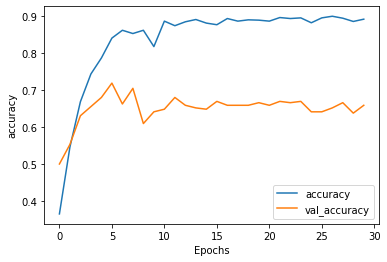

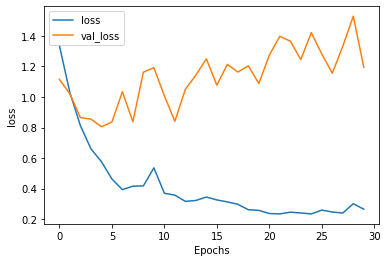

In [31]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activity_regularizer=l1(0.001))),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [33]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               93600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 254,404
Trainable params: 254,404
Non-trainable params: 0
_________________________________________________________________


In [34]:
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
36/36 - 11s - loss: 1.3198 - accuracy: 0.3917 - val_loss: 1.1493 - val_accuracy: 0.5000
Epoch 2/30
36/36 - 14s - loss: 1.0721 - accuracy: 0.5097 - val_loss: 1.0786 - val_accuracy: 0.5246
Epoch 3/30
36/36 - 9s - loss: 0.8750 - accuracy: 0.6127 - val_loss: 0.9366 - val_accuracy: 0.5458
Epoch 4/30
36/36 - 8s - loss: 0.6562 - accuracy: 0.7447 - val_loss: 1.0277 - val_accuracy: 0.6268
Epoch 5/30
36/36 - 8s - loss: 0.5419 - accuracy: 0.8187 - val_loss: 1.0892 - val_accuracy: 0.6338
Epoch 6/30
36/36 - 8s - loss: 0.4557 - accuracy: 0.8407 - val_loss: 0.9674 - val_accuracy: 0.6514
Epoch 7/30
36/36 - 9s - loss: 0.4624 - accuracy: 0.8495 - val_loss: 1.1227 - val_accuracy: 0.6338
Epoch 8/30
36/36 - 8s - loss: 0.3999 - accuracy: 0.8768 - val_loss: 0.9511 - val_accuracy: 0.6444
Epoch 9/30
36/36 - 9s - loss: 0.3725 - accuracy: 0.8732 - val_loss: 0.9606 - val_accuracy: 0.6655
Epoch 10/30
36/36 - 8s - loss: 0.3443 - accuracy: 0.8794 - val_loss: 1.1319 - val_accuracy: 0.6585
Epoch 11/30
36/36

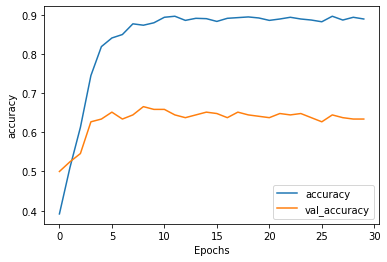

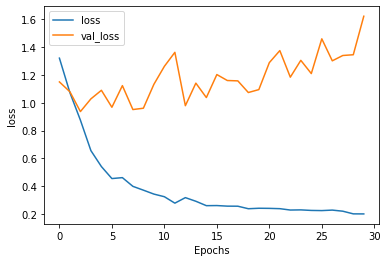

In [35]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
from tensorflow.keras.models import load_model

model.save('models/my_model')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('models/my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/my_model/assets


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               93600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 254,404
Trainable params: 254,404
Non-trainable params: 0
_________________________________________________________________


In [39]:
import pickle

# saving tokenizer
with open('models/tokenizer.pickle', 'wb') as tokenizerhandle:
    pickle.dump(tokenizer, tokenizerhandle, protocol=pickle.HIGHEST_PROTOCOL)
    tokenizerhandle.close()

# loading tokenizer
with open('models/tokenizer.pickle', 'rb') as tokenizerhandle:
    tokenizer = pickle.load(tokenizerhandle)
    tokenizerhandle.close()
    
# saving classes
with open('models/classes.pickle', 'wb') as classeshandle:
    pickle.dump(classes, classeshandle, protocol=pickle.HIGHEST_PROTOCOL)
    classeshandle.close()

# loading classes
with open('models/classes.pickle', 'rb') as classeshandle:
    classes = pickle.load(classeshandle)
    classeshandle.close()

In [48]:
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


def clean_data(transcription):
    lemmatizer = WordNetLemmatizer()
    message = re.sub('[^a-zA-Z]', ' ', str(transcription))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    return message



In [49]:
transcription = tokenizer.texts_to_sequences([clean_data('type')])

In [50]:
transcription

[[285]]

In [51]:
transcription = pad_sequences(transcription, padding = 'post', truncating = 'post', maxlen = 120)

In [52]:
transcription

array([[285,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [53]:
print(model.predict(transcription))

[[0.09287417 0.08647391 0.39541626 0.42523563]]


In [54]:
y_prob = model.predict(transcription) 
y_classes = y_prob.argmax(axis=-1)

In [55]:
y_classes[0]

3

In [56]:
classes[y_classes[0]]

' Surgery'

Data augmentation using nlpaug

In [60]:
import pandas as pd
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [92]:
df = pd.read_csv('transcription_samples.csv', usecols=['medical_specialty', 'transcription'])

In [93]:
df = df.dropna()

In [94]:
df.medical_specialty.value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

In [95]:
######### balancing dataset
def balance_dataset(df):
    df1 = df[df.medical_specialty == ' Consult - History and Phy.'].iloc[:355]
    df2 = df[df.medical_specialty == ' Cardiovascular / Pulmonary'].iloc[:355]
    df3 = df[df.medical_specialty == ' Orthopedic'].iloc[:355]
    df4 = df[df.medical_specialty == ' Surgery'].iloc[:355]
    
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)

df = balance_dataset(df)

In [96]:
df.medical_specialty.value_counts()

 Orthopedic                    355
 Surgery                       355
 Cardiovascular / Pulmonary    355
 Consult - History and Phy.    355
Name: medical_specialty, dtype: int64

In [97]:
df = df.reset_index(drop=True)

In [98]:
def augment(df):
    aug_syn = naw.SynonymAug(aug_src='wordnet')
    # augmented_text = aug_syn.augment(text)
    augmented_texts = []
    labels = []
    for i in range(df.shape[0]):
        text = df.transcription[i]
        label = df.medical_specialty[i]
        for j in range(10):
            augmented_text = aug_syn.augment(text)
            augmented_texts.append(augmented_text)
            labels.append(label)

    data = {'transcription': augmented_texts, 'medical_specialty': labels}
    df = pd.DataFrame(data)
    return df

df = augment(df)

In [99]:
df.medical_specialty.value_counts()

 Orthopedic                    3550
 Surgery                       3550
 Consult - History and Phy.    3550
 Cardiovascular / Pulmonary    3550
Name: medical_specialty, dtype: int64

 Consult - History and Phy.    3550
 Cardiovascular / Pulmonary    3550
Name: medical_specialty, dtype: int64

In [35]:
bilstm_prediction = model.predict_classes(validation_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [36]:
bilstm_prediction

array([2, 0, 1, 2, 0, 1, 2, 3, 0, 1, 1, 2, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3,
       1, 3, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3,
       1, 1, 3, 0, 3, 1, 0, 2, 3, 0, 0, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1,
       3, 1, 3, 3, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 0, 1, 1, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 2, 3, 3, 1, 2, 2, 3, 3, 1, 3, 0, 0,
       0, 0, 0, 1, 2, 0, 3, 3, 2, 3, 3, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 2,
       3, 1, 3, 3, 0, 0, 2, 1, 1, 0, 1, 0, 3, 3, 3, 2, 0, 3, 2, 0, 3, 0,
       1, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 3, 3, 0, 3, 0, 3, 3, 0, 1, 3, 0,
       0, 3, 3, 3, 0, 3, 0, 3, 2, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3,
       1, 0, 3, 0, 0, 1, 3, 0, 3, 2, 3, 1, 0, 2, 1, 1, 3, 0, 3, 3, 2, 0,
       2, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       3, 2, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 3, 3, 1, 0, 1, 1])

In [37]:
np.argmax(model.predict(validation_padded), axis=-1)

array([2, 0, 1, 2, 0, 1, 2, 3, 0, 1, 1, 2, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3,
       1, 3, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3,
       1, 1, 3, 0, 3, 1, 0, 2, 3, 0, 0, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1,
       3, 1, 3, 3, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 0, 1, 1, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 2, 3, 3, 1, 2, 2, 3, 3, 1, 3, 0, 0,
       0, 0, 0, 1, 2, 0, 3, 3, 2, 3, 3, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 2,
       3, 1, 3, 3, 0, 0, 2, 1, 1, 0, 1, 0, 3, 3, 3, 2, 0, 3, 2, 0, 3, 0,
       1, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 3, 3, 0, 3, 0, 3, 3, 0, 1, 3, 0,
       0, 3, 3, 3, 0, 3, 0, 3, 2, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3,
       1, 0, 3, 0, 0, 1, 3, 0, 3, 2, 3, 1, 0, 2, 1, 1, 3, 0, 3, 3, 2, 0,
       2, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       3, 2, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 3, 3, 1, 0, 1, 1])